In [39]:
import os
import pyspark 
from pyspark.sql import SparkSession
import sys

In [2]:
!pip install findspark

In [40]:
import findspark
findspark.init() 

In [41]:
spark = SparkSession.builder.appName('LinearReg').getOrCreate()

In [42]:
df = spark.read.parquet('cleaned_listings.parquet')


In [43]:
print(df.columns)

['id', 'name', 'summary', 'longitude', 'latitude', 'space', 'description', 'instant_bookable', 'neighborhood_overview', 'neighbourhood_cleansed', 'host_id', 'host_name', 'host_since', 'host_response_time', 'street', 'zipcode', 'review_scores_rating', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'reviews_per_month', 'amenities', 'cancellation_policy', 'number_of_reviews', 'price']


In [45]:
new_df=df[['room_type','property_type','bedrooms','amenities','bathrooms','beds','price']]

In [46]:
print(new_df.columns)

['room_type', 'property_type', 'bedrooms', 'amenities', 'bathrooms', 'beds', 'price']


In [47]:
new_df.show(2,truncate=False)

+---------------+-------------+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+----+-----+
|room_type      |property_type|bedrooms|amenities                                                                                                                                                                                                                                          |bathrooms|beds|price|
+---------------+-------------+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+----+-----+
|Entire home/apt|Apartment    |1.0     |{TV,"Cable TV",Internet,"Wireless Internet

In [48]:
#Encode Amenities
from pyspark.sql.functions import col

new_df.groupBy('amenities').count().orderBy('count', ascending=False).show()


+--------------------+-----+
|           amenities|count|
+--------------------+-----+
|                  {}|   22|
|{Internet,"Wirele...|   11|
|{TV,"Cable TV",In...|   10|
|{TV,"Cable TV",In...|    6|
|{TV,Internet,"Wir...|    6|
|{Internet,"Wirele...|    6|
|{TV,"Cable TV",In...|    6|
|{TV,Internet,"Wir...|    6|
|{TV,"Cable TV",In...|    5|
|{TV,Internet,"Wir...|    5|
|{TV,"Cable TV",In...|    5|
|{TV,Internet,"Wir...|    5|
|{Internet,"Wirele...|    5|
|{TV,"Cable TV",In...|    5|
|{Internet,"Wirele...|    5|
|{TV,"Cable TV",In...|    5|
|{TV,"Cable TV",In...|    5|
|{TV,"Cable TV",In...|    5|
|{TV,Internet,"Wir...|    4|
|{TV,"Cable TV",In...|    4|
+--------------------+-----+
only showing top 20 rows



In [49]:
from pyspark.sql.functions import regexp_replace, split

# Create a set of all possible amenities
amenities_set = (
    new_df
    .select("amenities")
    .rdd
    .flatMap(lambda row: row.amenities.replace('{', '').replace('}', '').replace('"', '').split(','))
    .map(lambda amenity: amenity.strip())
    .distinct()
    .collect()
)

In [50]:
# Splitting and creating dedicated columns for each amenity
for amenity in amenities_set:
    new_df = new_df.withColumn(amenity, col("amenities").contains(amenity).cast("int"))


In [51]:
# Drop the original 'amenities' column
new_df = new_df.drop("amenities")

In [52]:
print(new_df.columns)

['room_type', 'property_type', 'bedrooms', 'bathrooms', 'beds', 'price', 'TV', 'Cable TV', 'Internet', 'Wireless Internet', 'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Free Parking on Premises', 'Buzzer/Wireless Intercom', 'Smoke Detector', 'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card', 'Fire Extinguisher', 'Essentials', 'Pets Allowed', 'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub', 'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in', 'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace', 'Suitable for Events', 'Elevator in Building', 'Wheelchair Accessible', 'Gym', '', 'Lock on Bedroom Door', 'Pool', 'Other pet(s)', 'Smoking Allowed', 'Doorman', 'Washer / Dryer']


In [53]:
new_df.show(1,truncate=False)

+---------------+-------------+--------+---------+----+-----+---+--------+--------+-----------------+----------------+-------+-------+-------------------+------+-----+------------------------+------------------------+--------------+------------------------+-------------+-----------+-----------------+----------+------------+--------------------------+------+------+-------+----------------+-------+---------+----------------+-------+----------+----+-------------------------+-------------------+--------------------+---------------------+---+---+--------------------+----+------------+---------------+-------+--------------+
|room_type      |property_type|bedrooms|bathrooms|beds|price|TV |Cable TV|Internet|Wireless Internet|Air Conditioning|Kitchen|Heating|Family/Kid Friendly|Washer|Dryer|Free Parking on Premises|Buzzer/Wireless Intercom|Smoke Detector|Carbon Monoxide Detector|First Aid Kit|Safety Card|Fire Extinguisher|Essentials|Pets Allowed|Pets live on this property|Dog(s)|Cat(s)|Hot Tub|

In [54]:
new_df.groupBy('room_type').count().orderBy('count', ascending=False).show()


+---------------+-----+
|      room_type|count|
+---------------+-----+
|Entire home/apt| 1818|
|   Private room|  950|
|    Shared room|   92|
+---------------+-----+



In [55]:
#Encode room type
from pyspark.sql.functions import when

# List of distinct room types
room_types = ['Entire home/apt', 'Private room', 'Shared room']

# Loop through each room type and create a new column for each
for room_type in room_types:
    new_df = new_df.withColumn(room_type.replace(" ", "_").lower(), when(col("room_type") == room_type, 1).otherwise(0))

# Drop the original 'room_type' column
new_df = new_df.drop("room_type")


In [56]:
print(new_df.columns)

['property_type', 'bedrooms', 'bathrooms', 'beds', 'price', 'TV', 'Cable TV', 'Internet', 'Wireless Internet', 'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Free Parking on Premises', 'Buzzer/Wireless Intercom', 'Smoke Detector', 'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card', 'Fire Extinguisher', 'Essentials', 'Pets Allowed', 'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub', 'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in', 'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace', 'Suitable for Events', 'Elevator in Building', 'Wheelchair Accessible', 'Gym', '', 'Lock on Bedroom Door', 'Pool', 'Other pet(s)', 'Smoking Allowed', 'Doorman', 'Washer / Dryer', 'entire_home/apt', 'private_room', 'shared_room']


In [57]:
new_df.show(1,truncate=False)

+-------------+--------+---------+----+-----+---+--------+--------+-----------------+----------------+-------+-------+-------------------+------+-----+------------------------+------------------------+--------------+------------------------+-------------+-----------+-----------------+----------+------------+--------------------------+------+------+-------+----------------+-------+---------+----------------+-------+----------+----+-------------------------+-------------------+--------------------+---------------------+---+---+--------------------+----+------------+---------------+-------+--------------+---------------+------------+-----------+
|property_type|bedrooms|bathrooms|beds|price|TV |Cable TV|Internet|Wireless Internet|Air Conditioning|Kitchen|Heating|Family/Kid Friendly|Washer|Dryer|Free Parking on Premises|Buzzer/Wireless Intercom|Smoke Detector|Carbon Monoxide Detector|First Aid Kit|Safety Card|Fire Extinguisher|Essentials|Pets Allowed|Pets live on this property|Dog(s)|Cat(s)

In [58]:
new_df.groupBy('property_type').count().orderBy('count', ascending=False).show()


+---------------+-----+
|  property_type|count|
+---------------+-----+
|          House| 1408|
|      Apartment| 1204|
|      Townhouse|   80|
|    Condominium|   68|
|Bed & Breakfast|   26|
|           Loft|   22|
|          Cabin|   17|
|          Other|   13|
|      Camper/RV|    8|
|           Boat|    5|
|           Tent|    4|
|       Bungalow|    2|
|      Treehouse|    1|
|           Dorm|    1|
|         Chalet|    1|
+---------------+-----+



In [59]:
# Encode property_type
from pyspark.sql.functions import when

# List of distinct property types
property_types = ['House', 'Apartment', 'Townhouse', 'Condominium', 'Bed & Breakfast',
                  'Loft', 'Cabin', 'Other', 'Camper/RV', 'Boat', 'Tent', 'Bungalow',
                  'Treehouse', 'Dorm', 'Chalet']

# Loop through each property type and create a new column for each
for property_type in property_types:
    new_df = new_df.withColumn(property_type.replace(" ", "_").lower(), when(col("property_type") == property_type, 1).otherwise(0))

# Drop the original 'property_type' column
new_df = new_df.drop("property_type")


In [60]:
print(new_df.columns)

['bedrooms', 'bathrooms', 'beds', 'price', 'TV', 'Cable TV', 'Internet', 'Wireless Internet', 'Air Conditioning', 'Kitchen', 'Heating', 'Family/Kid Friendly', 'Washer', 'Dryer', 'Free Parking on Premises', 'Buzzer/Wireless Intercom', 'Smoke Detector', 'Carbon Monoxide Detector', 'First Aid Kit', 'Safety Card', 'Fire Extinguisher', 'Essentials', 'Pets Allowed', 'Pets live on this property', 'Dog(s)', 'Cat(s)', 'Hot Tub', 'Indoor Fireplace', 'Shampoo', 'Breakfast', '24-Hour Check-in', 'Hangers', 'Hair Dryer', 'Iron', 'Laptop Friendly Workspace', 'Suitable for Events', 'Elevator in Building', 'Wheelchair Accessible', 'Gym', '', 'Lock on Bedroom Door', 'Pool', 'Other pet(s)', 'Smoking Allowed', 'Doorman', 'Washer / Dryer', 'entire_home/apt', 'private_room', 'shared_room', 'house', 'apartment', 'townhouse', 'condominium', 'bed_&_breakfast', 'loft', 'cabin', 'other', 'camper/rv', 'boat', 'tent', 'bungalow', 'treehouse', 'dorm', 'chalet']


In [61]:
new_df.show(1,truncate=False)

+--------+---------+----+-----+---+--------+--------+-----------------+----------------+-------+-------+-------------------+------+-----+------------------------+------------------------+--------------+------------------------+-------------+-----------+-----------------+----------+------------+--------------------------+------+------+-------+----------------+-------+---------+----------------+-------+----------+----+-------------------------+-------------------+--------------------+---------------------+---+---+--------------------+----+------------+---------------+-------+--------------+---------------+------------+-----------+-----+---------+---------+-----------+---------------+----+-----+-----+---------+----+----+--------+---------+----+------+
|bedrooms|bathrooms|beds|price|TV |Cable TV|Internet|Wireless Internet|Air Conditioning|Kitchen|Heating|Family/Kid Friendly|Washer|Dryer|Free Parking on Premises|Buzzer/Wireless Intercom|Smoke Detector|Carbon Monoxide Detector|First Aid Kit|

In [62]:
# Split the data
from pyspark.sql.functions import rand
# Define the split ratios
train_ratio = 0.8
test_ratio = 0.2

# Split the DataFrame into train and test
train_df, test_df = new_df.randomSplit([train_ratio, test_ratio], seed=42)

# Show the number of rows in each split
print("Number of rows in df:",new_df.count())
print("Number of rows in train set:", train_df.count())
print("Number of rows in test set:", test_df.count())

Number of rows in df: 2860
Number of rows in train set: 2337
Number of rows in test set: 523


In [63]:
# Get the index of 'price' column
price_index = new_df.columns.index('price')
print("Index of 'price' column:", price_index)

Index of 'price' column: 3


In [64]:
price_column_index = 3
# Define a function to extract features and label from each row
def extract_features_label(row, price_column_index):
    features = row[:price_column_index] + row[price_column_index+1:]  # Extract all columns except the 'price' column
    label = row[price_column_index]  # Extract the 'price' column
    return (features, label)
transformed_rdd = train_df.rdd.map(lambda row: extract_features_label(row, price_column_index))


In [65]:
print(transformed_rdd.first())

((1.0, 0.5, 1.0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0), 40.0)


In [84]:
import numpy as np
num_features = len(transformed_rdd.first()[0])
print("num_features: "+ str(num_features))
weights = np.random.rand(num_features)


num_features: 63


In [85]:
# Define the Hypothesis Function
def hypothesis(x, weights):
    print(x)
    return np.dot(x, weights)

In [86]:
# Define the Cost Function
def cost_function(data, weights):
    squared_errors = data.map(lambda point: (hypothesis(point[0], weights) - point[1]) ** 2)
    return squared_errors.reduce(lambda x, y: x + y) / (2 * 2337)


In [87]:
# Gradient Descent
def gradient_descent(data, weights, learning_rate):
    gradients = data.map(lambda point: np.multiply(hypothesis(point[0], weights) - point[1], point[0]))
    gradient_sum = gradients.reduce(lambda x, y: np.add(x, y))
    return np.subtract(weights, np.multiply(learning_rate /2337, gradient_sum))


In [88]:
# Hyperparameters
learning_rate = 0.00090
num_iterations = 500

In [89]:
# Training loop
train_no=1
cost_values=[]
for _ in range(num_iterations):
    print("train no: "+str(train_no))
    weights = gradient_descent(transformed_rdd, weights, learning_rate)
    cost = cost_function(transformed_rdd, weights)
    cost_values.append(cost)
    train_no+=1
    print("Cost:", cost)

train no: 1
Cost: 10744.247305496196
train no: 2
Cost: 10463.022518855794
train no: 3
Cost: 10191.689475370395
train no: 4
Cost: 9929.898406604912
train no: 5
Cost: 9677.311915664855
train no: 6
Cost: 9433.604539597949
train no: 7
Cost: 9198.46232727429
train no: 8
Cost: 8971.582432197509
train no: 9
Cost: 8752.672719718776
train no: 10
Cost: 8541.451388144056
train no: 11
Cost: 8337.646603243484
train no: 12
Cost: 8140.996145688721
train no: 13
Cost: 7951.247070960736
train no: 14
Cost: 7768.155381287331
train no: 15
Cost: 7591.485709184526
train no: 16
Cost: 7421.01101219174
train no: 17
Cost: 7256.5122784044215
train no: 18
Cost: 7097.778242422479
train no: 19
Cost: 6944.605111346107
train no: 20
Cost: 6796.796300463401
train no: 21
Cost: 6654.162178287072
train no: 22
Cost: 6516.519820609733
train no: 23
Cost: 6383.692773258381
train no: 24
Cost: 6255.510823240761
train no: 25
Cost: 6131.809777986515
train no: 26
Cost: 6012.431252396896
train no: 27
Cost: 5897.222463426877
train no

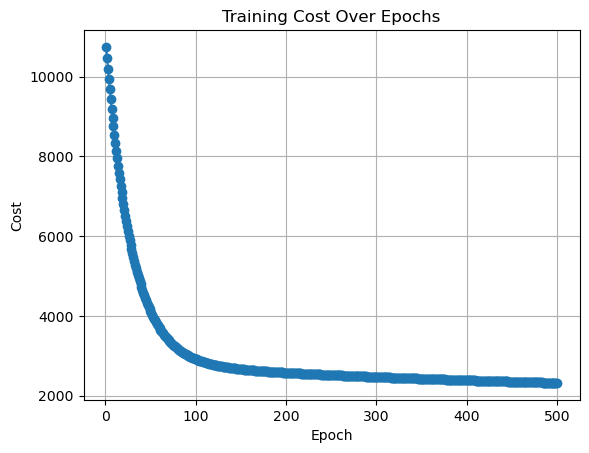

In [90]:
# Test convergence
import matplotlib.pyplot as plt
# Assuming cost_values is a list containing cost values at each epoch
# Plotting the cost values
plt.plot(range(1, len(cost_values) + 1), cost_values, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Cost')
plt.title('Training Cost Over Epochs')
plt.grid(True)
plt.show()

In [91]:
test_rdd = test_df.rdd.map(lambda row: extract_features_label(row, price_column_index))

In [92]:
predictions = test_rdd.map(lambda point: (hypothesis(point[0], weights), point[1]))
predictions_list = predictions.collect()
for prediction,label in predictions_list:
    print("prediction: ",prediction)
    print("label: ",label)
    print("======================================")


prediction:  76.45045955435435
label:  49.0
prediction:  76.45045955435435
label:  53.0
prediction:  79.43424413025188
label:  55.0
prediction:  76.45045955435435
label:  65.0
prediction:  97.89273733956125
label:  22.0
prediction:  90.89622266066415
label:  28.0
prediction:  95.49735462784975
label:  30.0
prediction:  99.17817874726839
label:  34.0
prediction:  97.7837628476656
label:  35.0
prediction:  99.17817874726839
label:  35.0
prediction:  97.90650748254082
label:  35.0
prediction:  99.34766618443132
label:  35.0
prediction:  104.5372973957978
label:  35.0
prediction:  111.97434134234395
label:  36.0
prediction:  87.45122847834841
label:  38.0
prediction:  80.18337196169456
label:  39.0
prediction:  100.43035869379258
label:  39.0
prediction:  95.46537657736678
label:  40.0
prediction:  85.49120683651599
label:  41.0
prediction:  97.71458951918471
label:  41.0
prediction:  96.96099371154244
label:  41.0
prediction:  107.57193964750694
label:  41.0
prediction:  111.9743413423439

In [93]:
import numpy as np

# Define a function to calculate Mean Absolute Error (MAE)
def calculate_mae(predictions):
    mae = np.mean([abs(pred[0] - pred[1]) for pred in predictions])
    return mae

# Define a function to calculate Mean Squared Error (MSE)
def calculate_mse(predictions):
    mse = np.mean([(pred[0] - pred[1]) ** 2 for pred in predictions])
    return mse

# Define a function to calculate Root Mean Squared Error (RMSE)
def calculate_rmse(predictions):
    mse = calculate_mse(predictions)
    rmse = np.sqrt(mse)
    return rmse


# Calculate evaluation metrics
mae = calculate_mae(predictions_list)
mse = calculate_mse(predictions_list)
rmse = calculate_rmse(predictions_list)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 45.63562118303757
Mean Squared Error (MSE): 5115.141809964906
Root Mean Squared Error (RMSE): 71.52021958834374


In [94]:
# Train prediction
predictions = transformed_rdd.map(lambda point: (hypothesis(point[0], weights), point[1]))
predictions_list = predictions.collect()
for prediction,label in predictions_list:
    print("prediction: ",prediction)
    print("label: ",label)
    print("======================================")


prediction:  84.60095312836263
label:  40.0
prediction:  76.45045955435435
label:  49.0
prediction:  76.45045955435435
label:  49.0
prediction:  76.45045955435435
label:  49.0
prediction:  74.0069124943148
label:  50.0
prediction:  76.45045955435435
label:  53.0
prediction:  76.45045955435435
label:  55.0
prediction:  85.5644473160163
label:  65.0
prediction:  87.2146177360842
label:  65.0
prediction:  76.45045955435435
label:  65.0
prediction:  84.04665914800194
label:  75.0
prediction:  73.67461691621396
label:  79.0
prediction:  87.09853701635875
label:  95.0
prediction:  75.50278420249415
label:  150.0
prediction:  99.54067455587935
label:  65.0
prediction:  97.73473722210068
label:  25.0
prediction:  99.97914450776616
label:  25.0
prediction:  108.03647440216884
label:  25.0
prediction:  92.92432095761711
label:  28.0
prediction:  94.91903037424265
label:  29.0
prediction:  94.58080742910838
label:  29.0
prediction:  82.86807412589334
label:  30.0
prediction:  92.52809750823418
la

In [95]:
# Calculate evaluation metrics
mae = calculate_mae(predictions_list)
mse = calculate_mse(predictions_list)
rmse = calculate_rmse(predictions_list)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 43.23674563723887
Mean Squared Error (MSE): 4636.065611986222
Root Mean Squared Error (RMSE): 68.08865993677819
